In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
import matplotlib.pylab as plt
%matplotlib inline

import os
import numpy as np
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
path2data = './gan_data'
os.makedirs(path2data, exist_ok=True)

In [3]:
train_ds = datasets.MNIST(path2data, train=True,
                         transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5],
                                                                                                   [0.5])]), download=True)

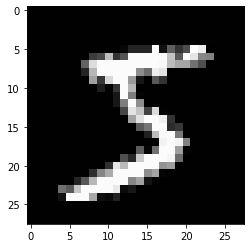

In [4]:
img, label = train_ds[0]
plt.imshow(to_pil_image(img), cmap='gray')

In [5]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

for x,y in train_dl:
    print(x.shape, y.shape)
    break

torch.Size([32, 1, 28, 28]) torch.Size([32])


In [6]:
class Generator(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.nz = params['nz']
        self.img_size = params['img_size']
        
        self.model = nn.Sequential(
            *self._fc_layer(self.nz, 128, normalize=False),
            *self._fc_layer(128,256),
            *self._fc_layer(256,512),
            *self._fc_layer(512,1024),
            nn.Linear(1024, int(np.prod(self.img_size))),
            nn.Tanh()
        )
        
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_size)
        return img
    
    def _fc_layer(self, in_channels, out_channels, normalize=True):
        layers = []
        layers.append(nn.Linear(in_channels, out_channels))
        if normalize:
            layers.append(nn.BatchNorm1d(out_channels, 0.8))
        layers.append(nn.LeakyReLU(0.2))
        return layers
    
params = {'nz': 100,
         'img_size':(1,28,28)}
x = torch.randn(16,100).to(device)
model_gen = Generator(params).to(device)
output = model_gen(x)
print(output.shape)

torch.Size([16, 1, 28, 28])


In [7]:
class Discriminator(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.img_size = params['img_size']
        
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(self.img_size)), 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512,256),
            nn.LeakyReLU(0.2),
            nn.Linear(256,1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x

x = torch.randn(16,1,28,28).to(device)
model_dis = Discriminator(params).to(device)
output = model_dis(x)
print(output.shape)

torch.Size([16, 1])


In [8]:
def initialize_weights(model):
    classname = model.__class__.__name__
    
    if classname.find('Linear') != -1:
        nn.init.normal_(model.weight.data, 0.0,0.02)
        nn.init.constant_(model.bias.data, 0)
        
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

model_gen.apply(initialize_weights);
model_dis.apply(initialize_weights);

In [16]:
loss_func = nn.BCELoss()

from torch import optim

lr = 2e-4
beta1=0.5

opt_dis = optim.Adam(model_dis.parameters(), lr=lr, betas = (beta1,0.999))
opt_gen = optim.Adam(model_gen.parameters(), lr=lr, betas = (beta1,0.999))

In [17]:
real_label =1.
fake_label =0.
nz = params['nz']
num_epochs = 100

loss_history= {'gen':[],
               'dis':[]}

In [20]:
batch_count = 0
start_time = time.time()
model_dis.train()
model_gen.train()

for epoch in range(num_epochs):
    for xb, yb in train_dl:
        ba_si = xb.size(0)
        
        xb = xb.to(device)
        yb_real = torch.Tensor(ba_si, 1).fill_(1.0).to(device)
        yb_fake = torch.Tensor(ba_si, 1).fill_(0.0).to(device)
        
        model_gen.zero_grad()
        noise = torch.randn(ba_si, nz, device=device)
        out_gen =model_gen(noise)
        out_dis = model_dis(out_gen)
        
        loss_gen = loss_func(out_dis, yb_real)
        loss_gen.backward()
        opt_gen.step()
        
        model_dis.zero_grad()
        
        out_real = model_dis(xb)
        out_fake = model_dis(out_gen.detach())
        loss_real = loss_func(out_real, yb_real)
        loss_fake = loss_func(out_fake, yb_fake)
        loss_dis = (loss_real + loss_fake) / 2
        
        loss_dis.backward()
        opt_dis.step()
        
        loss_history['gen'].append(loss_gen.item())
        loss_history['dis'].append(loss_dis.item())
        
        batch_count +=1
        if batch_count % 1000 ==0:
            print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, time: %.2f min' %(epoch, loss_gen.item(),
                                                                             loss_dis.item(), (time.time() - start_time)/60))
        

Epoch: 0, G_Loss: 1.320275, D_Loss: 0.300906, time: 0.82 min
Epoch: 1, G_Loss: 0.200445, D_Loss: 0.890927, time: 1.65 min
Epoch: 1, G_Loss: 1.467200, D_Loss: 0.300173, time: 2.51 min
Epoch: 2, G_Loss: 2.579363, D_Loss: 0.317045, time: 3.39 min
Epoch: 2, G_Loss: 2.876921, D_Loss: 0.338064, time: 4.24 min
Epoch: 3, G_Loss: 2.834472, D_Loss: 0.311743, time: 5.03 min
Epoch: 3, G_Loss: 1.647935, D_Loss: 0.268050, time: 5.71 min
Epoch: 4, G_Loss: 3.002031, D_Loss: 0.251153, time: 6.41 min
Epoch: 4, G_Loss: 2.552371, D_Loss: 0.144602, time: 7.11 min
Epoch: 5, G_Loss: 4.715493, D_Loss: 0.687775, time: 7.82 min
Epoch: 5, G_Loss: 2.199317, D_Loss: 0.181209, time: 8.51 min
Epoch: 6, G_Loss: 1.018975, D_Loss: 0.265983, time: 9.20 min
Epoch: 6, G_Loss: 1.910239, D_Loss: 0.168536, time: 9.90 min
Epoch: 7, G_Loss: 6.719062, D_Loss: 0.827666, time: 10.59 min
Epoch: 7, G_Loss: 3.122081, D_Loss: 0.304061, time: 11.29 min
Epoch: 8, G_Loss: 2.468286, D_Loss: 0.132911, time: 11.98 min
Epoch: 9, G_Loss: 3.2

KeyboardInterrupt: 